In [1]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Input
from keras.models import Sequential, Model
from keras.layers import Layer
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import img_to_array, load_img


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/data/Dataset/"
train, test = "Train", "Test"
train_path = path + train
test_path = path + test

def images_to_tensor(folder_path):
  images, target = [], []
  for id, label in enumerate(os.listdir(folder_path)):
    label_path = os.path.join(folder_path, label)
    for filename in os.listdir(label_path):
      file_path = os.path.join(label_path, filename)
      image = load_img(file_path, target_size = (224, 224))
      image = img_to_array(image)
      images.append(image)
      target.append(id)
  return tf.convert_to_tensor(images), target


In [4]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 416 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


## Build from scratch

In [18]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                      

In [19]:
model.compile(optimizer = 'Adam', loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [21]:
h = model.fit(training_set, batch_size = 32, epochs = 10, validation_data = test_set, verbose = 1)

Epoch 1/10
13/13 [==============================] - 53s 4s/step - loss: 12.4038 - accuracy: 0.6971 - val_loss: 2.3665 - val_accuracy: 0.6791
Epoch 2/10
13/13 [==============================] - 71s 6s/step - loss: 1.0138 - accuracy: 0.5529 - val_loss: 0.6937 - val_accuracy: 0.6567
Epoch 3/10
13/13 [==============================] - 75s 6s/step - loss: 0.6251 - accuracy: 0.5337 - val_loss: 0.6931 - val_accuracy: 0.6791
Epoch 4/10
13/13 [==============================] - 81s 6s/step - loss: 0.5645 - accuracy: 0.7019 - val_loss: 0.6971 - val_accuracy: 0.3209
Epoch 5/10
13/13 [==============================] - 69s 5s/step - loss: 0.5408 - accuracy: 0.7740 - val_loss: 0.7060 - val_accuracy: 0.3209
Epoch 6/10
13/13 [==============================] - 61s 4s/step - loss: 0.5055 - accuracy: 0.7692 - val_loss: 0.7276 - val_accuracy: 0.3209
Epoch 7/10
13/13 [==============================] - 53s 4s/step - loss: 0.5748 - accuracy: 0.7644 - val_loss: 0.6921 - val_accuracy: 0.3582
Epoch 8/10
13/13 [=

In [22]:
model.evaluate(test_set)

5/5 [==============================] - 4s 663ms/step - loss: 0.8305 - accuracy: 0.3209


[0.8304767608642578, 0.3208955228328705]

array([0., 1.], dtype=float32)

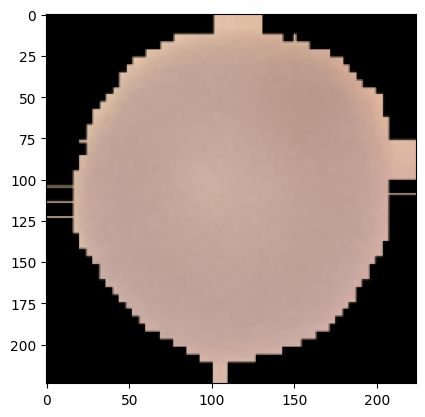

In [ ]:
plt.imshow(training_set[0][0][5])
training_set[0][1][5]

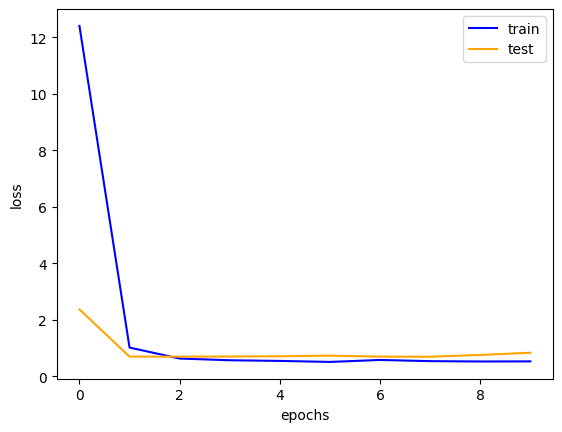

In [23]:
plt.plot(h.history['loss'], c = 'blue', label = 'train')
plt.plot(h.history['val_loss'], c= 'orange', label = 'test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Transfer Learning

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [ ]:
vggnet = VGG16(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)
# don't train existing weights
for layer in vggnet.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
x = Flatten()(vggnet.output)
prediction = Dense(2, activation = 'softmax')(x)
model = Model(inputs = vggnet.input, outputs = prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [ ]:
h = model.fit(training_set, batch_size = 32, epochs = 10, validation_data = test_set)

Epoch 1/10
13/13 [==============================] - 350s 27s/step - loss: 0.1666 - accuracy: 0.9543 - val_loss: 0.2616 - val_accuracy: 0.8881
Epoch 2/10
13/13 [==============================] - 351s 27s/step - loss: 0.1564 - accuracy: 0.9591 - val_loss: 0.2949 - val_accuracy: 0.8657
Epoch 3/10
13/13 [==============================] - 318s 25s/step - loss: 0.1456 - accuracy: 0.9736 - val_loss: 0.2112 - val_accuracy: 0.9254
Epoch 4/10
13/13 [==============================] - 357s 28s/step - loss: 0.1391 - accuracy: 0.9663 - val_loss: 0.2245 - val_accuracy: 0.9030
Epoch 5/10
13/13 [==============================] - 353s 27s/step - loss: 0.1618 - accuracy: 0.9519 - val_loss: 0.3521 - val_accuracy: 0.8134
Epoch 6/10
13/13 [==============================] - 307s 24s/step - loss: 0.1351 - accuracy: 0.9591 - val_loss: 0.2427 - val_accuracy: 0.8881
Epoch 7/10
13/13 [==============================] - 306s 24s/step - loss: 0.1305 - accuracy: 0.9663 - val_loss: 0.2936 - val_accuracy: 0.8657
Epoch 

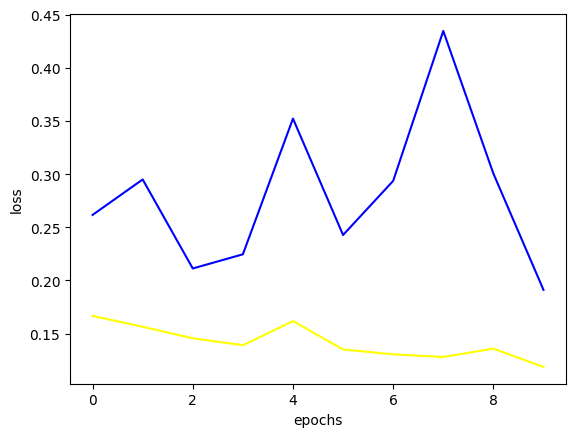

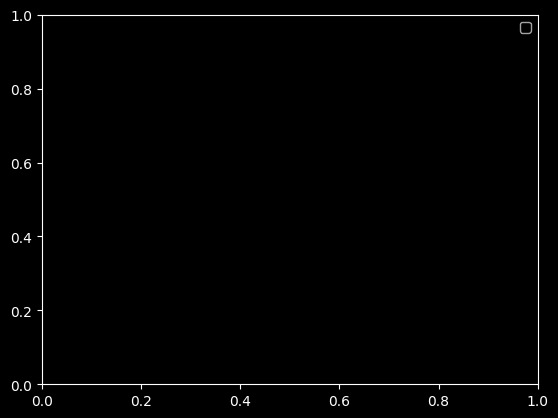

In [ ]:
plt.plot(h.history['loss'], c = 'yellow', label = 'train')
plt.plot(h.history['val_loss'], c = 'blue', label = 'test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.style.use('dark_background')
plt.show()
plt.legend()

## Functional API

In [ ]:
input = Input(shape = (224, 224, 3), name = "dang")

x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(input)
x = MaxPooling2D(pool_size = 2)(x)
x = BatchNormalization()(x)

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = MaxPooling2D(pool_size = 2)(x)
output = BatchNormalization()(x)

feature_extractor = Model(inputs = input, outputs = output)

In [ ]:
input = Input(shape = (224, 224, 3), name = 'dang nguyen')

x = feature_extractor(input)
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

last_output = Dense(2, activation = 'softmax')(x)
model = Model(inputs = input, outputs = last_output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dang nguyen (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 54, 54, 32)        5280      
                                                                 
 flatten_4 (Flatten)         (None, 93312)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                5972032   
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                           

In [ ]:
model.compile(optimizer = 'SGD', loss = keras.losses.categorical_crossentropy, metrics = 'accuracy')

In [ ]:
model.fit(training_set, batch_size = 32, epochs = 10, validation_data = test_set)

Epoch 1/10
13/13 [==============================] - 189s 15s/step - loss: 0.7015 - accuracy: 0.6899 - val_loss: 0.6633 - val_accuracy: 0.6791
Epoch 2/10
13/13 [==============================] - 26s 2s/step - loss: 0.4736 - accuracy: 0.7716 - val_loss: 0.6581 - val_accuracy: 0.6567
Epoch 3/10
13/13 [==============================] - 26s 2s/step - loss: 0.4157 - accuracy: 0.7812 - val_loss: 0.6367 - val_accuracy: 0.6791
Epoch 4/10
13/13 [==============================] - 26s 2s/step - loss: 0.4172 - accuracy: 0.8173 - val_loss: 0.6372 - val_accuracy: 0.6791
Epoch 5/10
13/13 [==============================] - 26s 2s/step - loss: 0.4089 - accuracy: 0.7692 - val_loss: 0.6284 - val_accuracy: 0.6791
Epoch 6/10
13/13 [==============================] - 27s 2s/step - loss: 0.3682 - accuracy: 0.8221 - val_loss: 0.6415 - val_accuracy: 0.6791
Epoch 7/10
13/13 [==============================] - 24s 2s/step - loss: 0.3227 - accuracy: 0.8630 - val_loss: 0.6391 - val_accuracy: 0.6791
Epoch 8/10
13/13 [

## Model Subclassing

In [36]:
class feature_extractor(Layer):
  def __init__(self, input_shape):
    super(feature_extractor, self).__init__()
    self.conv1 = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', input_shape = input_shape)
    self.maxpool1 = MaxPooling2D(pool_size = 2)
    self.batchnorm1 = BatchNormalization()

    self.conv2 = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')
    self.maxpool2 = MaxPooling2D(pool_size = 2)
    self.batchnorm2 = BatchNormalization()

  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.batchnorm1(x)

    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.batchnorm2(x)
    return x


In [40]:
input = Input(shape = (224, 224, 3))

x = feature_extractor(input_shape = (224, 224, 3))(input)
x = Flatten()(x)
output = Dense(2, activation = 'softmax')(x)
model = Model(inputs = input, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_7 (featu  (None, 54, 54, 32)        5280      
 re_extractor)                                                   
                                                                 
 flatten_8 (Flatten)         (None, 93312)             0         
                                                                 
 dense_16 (Dense)            (None, 2)                 186626    
                                                                 
Total params: 191906 (749.63 KB)
Trainable params: 191810 (749.26 KB)
Non-trainable params: 96 (384.00 Byte)
_________________________________________________________________


In [41]:
class my_model(Model):
  def __init__(self):
    super(my_model, self).__init__()
    self.extractor = feature_extractor(input_shape = (224, 224, 3))
    self.flatten = Flatten()
    self.fc2 = Dense(128, activation = 'relu')
    self.batchnorm = BatchNormalization()
    self.fc3 = Dense(2, activation = 'softmax')

  def call(self, x):
    x = self.extractor(x)
    x = self.flatten(x)
    x = self.fc2(x)
    x = self.batchnorm(x)
    x = self.fc3(x)
    return x


In [43]:
model = my_model()
model.build((None, 224, 224, 3))
model.summary()
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

Model: "my_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_9 (featu  multiple                  5280      
 re_extractor)                                                   
                                                                 
 flatten_10 (Flatten)        multiple                  0         
                                                                 
 dense_19 (Dense)            multiple                  11944064  
                                                                 
 batch_normalization_29 (Ba  multiple                  512       
 tchNormalization)                                               
                                                                 
 dense_20 (Dense)            multiple                  258       
                                                                 
Total params: 11950114 (45.59 MB)
Trainable params: 1194

In [44]:
h = model.fit(training_set, batch_size = 32, epochs = 10, validation_data = test_set, verbose = 1)

Epoch 1/10
13/13 [==============================] - 32s 2s/step - loss: 1.3915 - accuracy: 0.6659 - val_loss: 1.9147 - val_accuracy: 0.6716
Epoch 2/10
13/13 [==============================] - 30s 2s/step - loss: 0.6853 - accuracy: 0.7572 - val_loss: 0.8251 - val_accuracy: 0.6791
Epoch 3/10
13/13 [==============================] - 30s 2s/step - loss: 0.5942 - accuracy: 0.7644 - val_loss: 0.6826 - val_accuracy: 0.6791
Epoch 4/10
13/13 [==============================] - 30s 2s/step - loss: 0.4128 - accuracy: 0.7933 - val_loss: 0.6957 - val_accuracy: 0.6791
Epoch 5/10
13/13 [==============================] - 30s 2s/step - loss: 0.3601 - accuracy: 0.8245 - val_loss: 0.6837 - val_accuracy: 0.6791
Epoch 6/10
13/13 [==============================] - 30s 2s/step - loss: 0.3741 - accuracy: 0.8197 - val_loss: 0.6942 - val_accuracy: 0.6791
Epoch 7/10
13/13 [==============================] - 28s 2s/step - loss: 0.3116 - accuracy: 0.8630 - val_loss: 0.6850 - val_accuracy: 0.5970
Epoch 8/10
13/13 [==

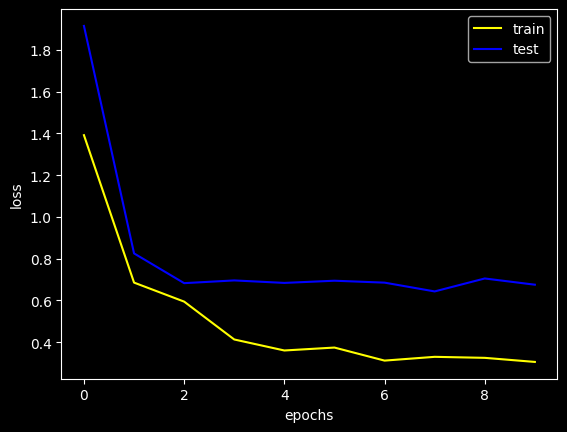

In [50]:
plt.plot(h.history['loss'], c = 'yellow', label = 'train')
plt.plot(h.history['val_loss'], c = 'blue', label = 'test')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()